In [ ]:
DATADIR="../tmp/data"

import pandas as pd
import os
ii=0
for root, dirs, files in os.walk(DATADIR):
    print(root)
    print(dirs)
    print(files)
    for f in files:
        d = pd.read_csv(DATADIR+"/"+f, error_bad_lines =False,names=['time','src','dst','proto', 'vol','src_port','dst_port'])
        dns=d[(d['dst_port']=='53')]
        dns.to_csv("dnsdata1/i"+str(ii)+".csv",index=False)
        ii+=1


In [ ]:

#################################
alldf=[]
for i in range(ii):
    df = pd.read_csv("dnsdata1/i"+str(i)+".csv");
    alldf.append(df)
df = pd.concat(alldf,axis=0,ignore_index=True)



In [ ]:
import pyasn

DEFAULT_ASNDB='../sfp-eval/ipasn.20190116.1600.dat'
asndb = pyasn.pyasn(DEFAULT_ASNDB)
# src_asn = asndb.lookup(columns[1])[0]

stat={}
for i,dd in df.iterrows():
    srcas = asndb.lookup(str(dd.src))[0]
    if not srcas:
        continue
    stat.setdefault(srcas,{})
    dnsserver = str(dd.dst)
    stat[srcas][dnsserver] = stat[srcas].get(dnsserver,0)+int(dd.vol)


In [84]:
with open('../sfp-eval/stubs.txt') as f:
    t =str(f.read())
    stubs = t.split()

In [108]:
stat2 = {k:v for k,v in stat.items() if str(k) in stubs}
t=[(k,sum(v.values())) for k,v in stat2.items()]
t.sort(key=lambda x:x[1],reverse=True)
total = t[0:50]
stat2 = [(i[0],stat2[i[0]]) for i in t[0:50]]

[19065, 200139, 36647, 32475, 16625, 11712, 714, 22552, 13238, 46746, 58411, 63949, 36351, 32244, 7046, 32906, 46912, 37963, 16509, 33070, 109, 25609, 32360, 29802, 12041, 18986, 14618, 23556, 53567, 62702, 17012, 14492, 23650, 18082, 30340, 19353, 15169, 38538, 34934, 29984, 11643, 3450, 46475, 22653, 16276, 20860, 20773, 18108, 1348, 25694]


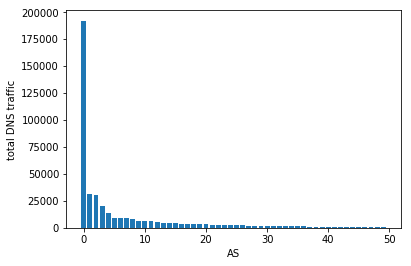

In [114]:
def plot1(total):
    xlabel = []
    y=[]
    for k,v in total:
        xlabel.append(k)
        y.append(v)
    print(xlabel)
    x=list(range(len(total)))
    plt.bar(x,y)
    plt.xlabel("AS")
    plt.ylabel("total DNS traffic")
    plt.savefig("totaldnstraffic.png",dpi=600,bbox_inches='tight')
plot1(total)

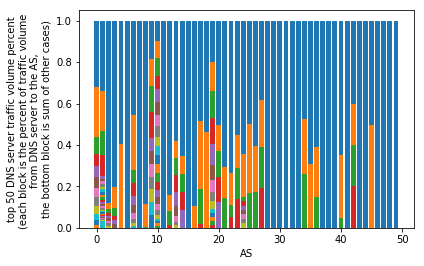

In [106]:

def plot2(stat2):
    xlabel=[]
    y=[]
    for k,v in stat2:
        xlabel.append(str(k))
        yy=list(v.values())
        y.append(yy)

    ml = max(len(yi) for yi in y)

    for yi in y:
        if len(yi)<ml:
            yi.extend([0 for _ in range(ml-len(yi))])
        yi.sort(reverse = True)

    x=list(range(len(xlabel)))

    ry=[]
    for yy in y:
        ry.append(list(sum(yy[i:])/float(sum(yy)) for i in range(50)))


    for i in range(min(ml,30)):
        py = [ry[ii][i] for ii in x]
        plt.bar(x, py)
    # plt.show()
    plt.xlabel('AS')
    plt.ylabel('top 50 DNS server traffic volume percent\n(each block is the percent of traffic volume \nfrom DNS server to the AS, \nthe bottom block is sum of other cases)')
    plt.savefig('result2.png',dpi=600, bbox_inches='tight')
    return xlabel

asnum = plot2(stat2)

In [116]:
import json
with open('dnsstat.json','w') as f:
    json.dump(stat, f)